# Introduction

In this project, you will build a neural network of your own design to evaluate the CIFAR-10 dataset.

To meet the requirements for this project, you will need to achieve an accuracy greater than 45%. 
If you want to beat Detectocorp's algorithm, you'll need to achieve an accuracy greater than 70%. 
(Beating Detectocorp's algorithm is not a requirement for passing this project, but you're encouraged to try!)

Some of the benchmark results on CIFAR-10 include:

78.9% Accuracy | [Deep Belief Networks; Krizhevsky, 2010](https://www.cs.toronto.edu/~kriz/conv-cifar10-aug2010.pdf)

90.6% Accuracy | [Maxout Networks; Goodfellow et al., 2013](https://arxiv.org/pdf/1302.4389.pdf)

96.0% Accuracy | [Wide Residual Networks; Zagoruyko et al., 2016](https://arxiv.org/pdf/1605.07146.pdf)

99.0% Accuracy | [GPipe; Huang et al., 2018](https://arxiv.org/pdf/1811.06965.pdf)

98.5% Accuracy | [Rethinking Recurrent Neural Networks and other Improvements for ImageClassification; Nguyen et al., 2020](https://arxiv.org/pdf/2007.15161.pdf)

Research with this dataset is ongoing. Notably, many of these networks are quite large and quite expensive to train. 

## Imports

In [1]:
## This cell contains the essential imports you will need – DO NOT CHANGE THE CONTENTS! ##
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np

## Load the Dataset

Specify your transforms as a list first.
The transforms module is already loaded as `transforms`.

CIFAR-10 is fortunately included in the torchvision module.
Then, you can create your dataset using the `CIFAR10` object from `torchvision.datasets` ([the documentation is available here](https://pytorch.org/vision/stable/generated/torchvision.datasets.CIFAR10.html)).
Make sure to specify `download=True`! 

Once your dataset is created, you'll also need to define a `DataLoader` from the `torch.utils.data` module for both the train and the test set.

In [2]:
# Define transforms
## YOUR CODE HERE ##
train_transforms = transforms.Compose([transforms.RandomRotation(60),
                                      transforms.RandomHorizontalFlip(),
                                      transforms.ColorJitter(brightness=0.5, hue=0.25),
                                      transforms.ToTensor(),
                                      transforms.Normalize([.5,.5,.5],
                                                           [.5,.5,.5])
                                      ])
    
test_transforms = transforms.Compose([transforms.ToTensor(),
                                     transforms.Normalize([.5,.5,.5],
                                                          [.5,.5,.5])
                                     ])

view_transform = transforms.Compose([transforms.ToTensor()])


# Create training set and define training dataloader
## YOUR CODE HERE ##
train_data = torchvision.datasets.CIFAR10(root= 'train', train=True, transform=train_transforms, download=True)
trainset, valset = torch.utils.data.dataset.random_split(train_data, [int(.8*len(train_data)), int(.2*len(train_data))])
trainloader = torch.utils.data.DataLoader(trainset, batch_size=32, shuffle=True)
valloader = torch.utils.data.DataLoader(valset, batch_size=32, shuffle=True)


# Create test set and define test dataloader
## YOUR CODE HERE ##
test_data = torchvision.datasets.CIFAR10(root='test', train=False, transform=test_transforms, download=True)
testloader = torch.utils.data.DataLoader(test_data, batch_size=32)

# Create test set just for viewing
view_data = torchvision.datasets.CIFAR10(root='test', train=False, transform=view_transform, download=True)
viewloader = torch.utils.data.DataLoader(view_data, batch_size=32)

# The 10 classes in the dataset
classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


## Explore the Dataset
Using matplotlib, numpy, and torch, explore the dimensions of your data.

You can view images using the `show5` function defined below – it takes a data loader as an argument.
Remember that normalized images will look really weird to you! You may want to try changing your transforms to view images.
Typically using no transforms other than `toTensor()` works well for viewing – but not as well for training your network.
If `show5` doesn't work, go back and check your code for creating your data loaders and your training/test sets.

In [3]:
def show5(img_loader):
    dataiter = iter(img_loader)
    
    batch = next(dataiter)
    labels = batch[1][0:5]
    images = batch[0][0:5]
    for i in range(5):
        print(classes[labels[i]])
    
        image = images[i].numpy()
        plt.imshow(np.rot90(image.T, k=3))
        plt.show()

cat


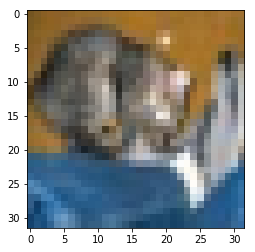

ship


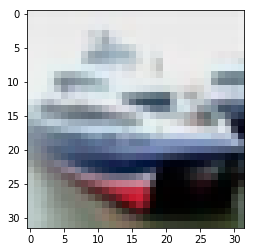

ship


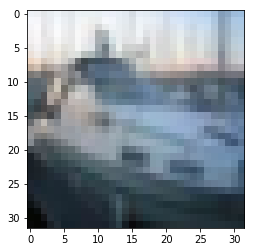

plane


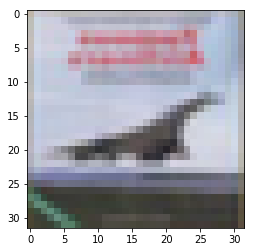

frog


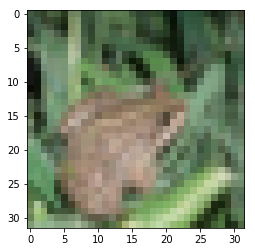

In [4]:
# Use show5
show5(viewloader)

In [5]:
print(train_data)
print(test_data)

Dataset CIFAR10
    Number of datapoints: 50000
    Split: train
    Root Location: train
    Transforms (if any): Compose(
                             RandomRotation(degrees=(-60, 60), resample=False, expand=False)
                             RandomHorizontalFlip(p=0.5)
                             ColorJitter(brightness=0.5, contrast=0, saturation=0, hue=0.25)
                             ToTensor()
                             Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
                         )
    Target Transforms (if any): None
Dataset CIFAR10
    Number of datapoints: 10000
    Split: test
    Root Location: test
    Transforms (if any): Compose(
                             ToTensor()
                             Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
                         )
    Target Transforms (if any): None


In [6]:
print("Training Data Dimensions:",train_data.train_data.data.shape)
print("Test Data Dimensions:", test_data.test_data.data.shape)

Training Data Dimensions: (50000, 32, 32, 3)
Test Data Dimensions: (10000, 32, 32, 3)


In [7]:
print("Training Set Observations:",len(trainloader.dataset))
print("Validation Set Observations:",len(valloader.dataset))
print("Test Set Observations:",len(testloader.dataset))

Training Set Observations: 40000
Validation Set Observations: 10000
Test Set Observations: 10000


## Build your Neural Network
Using the layers in `torch.nn` (which has been imported as `nn`) and the `torch.nn.functional` module (imported as `F`), construct a neural network based on the parameters of the dataset. 
Feel free to construct a model of any architecture – feedforward, convolutional, or even something more advanced!

In [24]:
# Network Architecture: Build a Network
# Using a Convolutional NN because it should be better for image classification
# Using the Pytorch tutorials as a guide on how to make a CNN

class Classifier(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 64, 5)
        self.fc1 = nn.Linear(1600, 512)
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, 128)
        self.fc4 = nn.Linear(128, 64)
        self.fc5 = nn.Linear(64, 10)
        
        # Dropout module with 0.25 drop probability
        self.dropout = nn.Dropout(p=0.25)
        
    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        
        x = x.view(x.shape[0], -1)
        
        x = self.dropout(F.relu(self.fc1(x)))
        x = self.dropout(F.relu(self.fc2(x)))
        x = self.dropout(F.relu(self.fc3(x)))
        x = self.dropout(F.relu(self.fc4(x)))
        x = F.log_softmax(self.fc5(x), dim=1)
        return x

In [25]:
model = Classifier()
model

Classifier(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 64, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=1600, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=256, bias=True)
  (fc3): Linear(in_features=256, out_features=128, bias=True)
  (fc4): Linear(in_features=128, out_features=64, bias=True)
  (fc5): Linear(in_features=64, out_features=10, bias=True)
  (dropout): Dropout(p=0.25)
)

Specify a loss function and an optimizer, and instantiate the model.

If you use a less common loss function, please note why you chose that loss function in a comment.

In [26]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

## Running your Neural Network
Use whatever method you like to train your neural network, and ensure you record the average loss at each epoch. 
Don't forget to use `torch.device()` and the `.to()` method for both your model and your data if you are using GPU!

If you want to print your loss during each epoch, you can use the `enumerate` function and print the loss after a set number of batches. 250 batches works well for most people!

In [27]:
# Use GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model.to(device);

epochs = 50
print_every = 250
train_losses, test_losses = [], []

for e in range(epochs):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()            
            
    else:
        test_loss = 0
        accuracy = 0
        with torch.no_grad():
            model.eval()
            for images, labels in valloader:
                images, labels = images.to(device), labels.to(device)
                output = model(images)
                batch_loss = criterion(output, labels)
                test_loss += batch_loss.item()
                
                ps = torch.exp(output)
                top_p, top_class = ps.topk(1, dim=1)
                equals = top_class == labels.view(*top_class.shape)
                accuracy += torch.mean(equals.type(torch.FloatTensor))
                
        model.train()
        
        train_losses.append(running_loss/len(trainloader))
        test_losses.append(test_loss/len(valloader))

        print("Epoch: {}/{}.. ".format(e+1, epochs),
              "Training Loss: {:.3f}.. ".format(train_losses[-1]),
              "Validation Loss: {:.3f}.. ".format(test_losses[-1]),
              "Validation Accuracy: {:.3f}".format(accuracy/len(valloader)))

print('Finished Training')


Epoch: 1/50..  Training Loss: 2.303..  Validation Loss: 2.300..  Validation Accuracy: 0.132
Epoch: 2/50..  Training Loss: 2.297..  Validation Loss: 2.288..  Validation Accuracy: 0.154
Epoch: 3/50..  Training Loss: 2.261..  Validation Loss: 2.200..  Validation Accuracy: 0.187
Epoch: 4/50..  Training Loss: 2.185..  Validation Loss: 2.113..  Validation Accuracy: 0.232
Epoch: 5/50..  Training Loss: 2.094..  Validation Loss: 2.015..  Validation Accuracy: 0.268
Epoch: 6/50..  Training Loss: 2.022..  Validation Loss: 1.968..  Validation Accuracy: 0.279
Epoch: 7/50..  Training Loss: 1.986..  Validation Loss: 1.928..  Validation Accuracy: 0.296
Epoch: 8/50..  Training Loss: 1.944..  Validation Loss: 1.881..  Validation Accuracy: 0.315
Epoch: 9/50..  Training Loss: 1.901..  Validation Loss: 1.832..  Validation Accuracy: 0.332
Epoch: 10/50..  Training Loss: 1.860..  Validation Loss: 1.773..  Validation Accuracy: 0.351
Epoch: 11/50..  Training Loss: 1.822..  Validation Loss: 1.756..  Validation Ac

Plot the training loss (and validation loss/accuracy, if recorded).

In [28]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

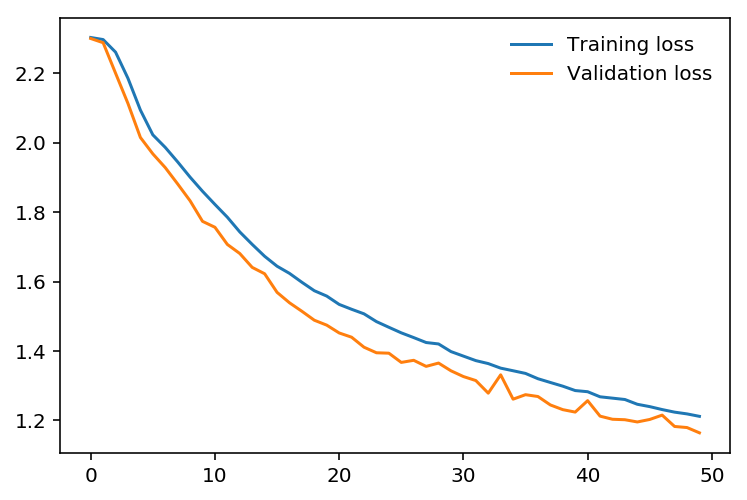

In [29]:
plt.plot(train_losses, label='Training loss')
plt.plot(test_losses, label='Validation loss')
plt.legend(frameon=False)

## Testing your model
Using the previously created `DataLoader` for the test set, compute the percentage of correct predictions using the highest probability prediction. 

If your accuracy is over 70%, great work! 
This is a hard task to exceed 70% on.

If your accuracy is under 45%, you'll need to make improvements.
Go back and check your model architecture, loss function, and optimizer to make sure they're appropriate for an image classification task.

In [30]:
# I was having trouble with the Dataloader object so I used the
# Pytorch tutorial as a template

correct = 0
total = 0
# since we're not training, we don't need to calculate the gradients for our outputs
with torch.no_grad():
    for data in testloader:
        images, labels = data
        images, labels = images.to("cuda"), labels.to("cuda")
        # calculate outputs by running images through the network
        outputs = model(images)
        # the class with the highest energy is what we choose as prediction
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy of the network on the 10000 test images: {100 * correct // total} %')

Accuracy of the network on the 10000 test images: 61 %


## Saving your model
Using `torch.save`, save your model for future loading.

In [15]:
PATH = './cifar_net.pth'
torch.save(model.state_dict(), PATH)

## Make a Recommendation

Based on your evaluation, what is your recommendation on whether to build or buy? Explain your reasoning below.

Some things to consider as you formulate your recommendation:
* How does your model compare to Detectocorp's model?
* How does it compare to the far more advanced solutions in the literature? 
* What did you do to get the accuracy you achieved? 
* Is it necessary to improve this accuracy? If so, what sort of work would be involved in improving it?

Compared to Detectocorp's model, my model is a little worse. It is much better than random chance, by classifying correctly just over 60% of the test cases. It is however much worse than the latest solutions, which are nearly perfect. I used a convolutional neural network since this is an image classifiation problem. I also implemented dropout in an effort to avoid overfitting. The accuracy needs to be much better, to improve I would attempt to use transfer learning and a pretrained CNN. I could also try to add another convolutional layer to the current model, and run more epochs (a faster GPU would help with this). Overall, I would inquire about the cost of a better GPU versus Detectocorp's model. If the GPU is much cheaper, it would be worth trying a larger network with more epochs. If the cost is similar, Detectocrop's model is more cost effective.

## Submit Your Project

When you are finished editing the notebook and are ready to turn it in, simply click the **SUBMIT PROJECT** button in the lower right.

Once you submit your project, we'll review your work and give you feedback if there's anything that you need to work on. If you'd like to see the exact points that your reviewer will check for when looking at your work, you can have a look over the project [rubric](https://review.udacity.com/#!/rubrics/3077/view).